## Accessing NAIP data with the Planetary Computer STAC API

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key.
The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to use your API key.

In [1]:
from pystac_client import Client
import planetary_computer as pc

# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# pc.settings.set_subscription_key(<YOUR API Key>)

### Choose our region and times of interest

This area is in South Jordan, Utah, which the Internet says is one of the fastest-growing cities in the US.  Let's see whether we can see some development in this area in the time spanned by our NAIP collection.

In [2]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-111.9839859008789,40.5389819819361],
            [-111.90502166748045,40.5389819819361],
            [-111.90502166748045,40.57015381856105],
            [-111.9839859008789,40.57015381856105],
            [-111.9839859008789,40.5389819819361]            
        ]
    ],
}

### Search the collection and choose scenes to render

Use [pystac-client](https://github.com/stac-utils/pystac-client) to search for data from the [NAIP](http://aka.ms/ai4edata-naip) collection.  This collection includes data from 2010 to 2019, so we'll search for one image near the beginning of that range, and one near the end.

In [3]:
range_old = '2010-01-01/2013-01-01'
range_new = '2018-01-01/2020-01-01'

In [4]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search_old = catalog.search(
    collections=['naip'], 
    intersects=area_of_interest,
    datetime = range_old
)

search_new = catalog.search(
    collections=['naip'], 
    intersects=area_of_interest,
    datetime = range_new
)

print(f"{search_old.matched()} Items found in the 'old' range")
print(f"{search_new.matched()} Items found in the 'new' range")

4 Items found in the 'old' range
4 Items found in the 'new' range


As seen above, there are multiple items that intersect our area of interest for each year. The following code will choose the item that has the most overlap:

In [5]:
from shapely.geometry import shape

area_shape = shape(area_of_interest)
target_area = area_shape.area

def area_of_overlap(item):
    overlap_area = shape(item.geometry).intersection(shape(area_of_interest)).area    
    return overlap_area / target_area

item_old = sorted(search_old.items(), key=area_of_overlap, reverse=True)[0]
item_new = sorted(search_new.items(), key=area_of_overlap, reverse=True)[0]

### Render images

Each Item has an `href` field containing a URL to the underlying image. For NAIP, these URLs are publicly-accessible, but for some data sets, these URLs may point to private containers, so we demonstrate the use of the [planetary-computer](https://github.com/microsoft/planetary-computer-sdk-for-python) package's `pc.sign` method, which adds a [Shared Access Signature](https://docs.microsoft.com/en-us/azure/storage/common/storage-sas-overview) to the URL, after which it can be used by any tooling that expects a standard URL.

In [6]:
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp

import numpy as np
from PIL import Image

def create_image(item):
    print(item.datetime)
    href = pc.sign(item.assets['image'].href)
    with rasterio.open(href) as ds:    
        aoi_bounds = features.bounds(area_of_interest)
        warped_aoi_bounds = warp.transform_bounds('epsg:4326', ds.crs, *aoi_bounds)
        aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
        band_data = ds.read(indexes=[1,2,3], window=aoi_window)
    
    img = Image.fromarray(np.transpose(band_data, axes=[1, 2, 0]))
    w = img.size[0]; h = img.size[1]; aspect = w/h
    
    # Downscale a bit for plotting
    target_w = 800; target_h = (int)(target_w/aspect)

    return img.resize((target_w,target_h),Image.BILINEAR)

2011-07-20 00:00:00+00:00


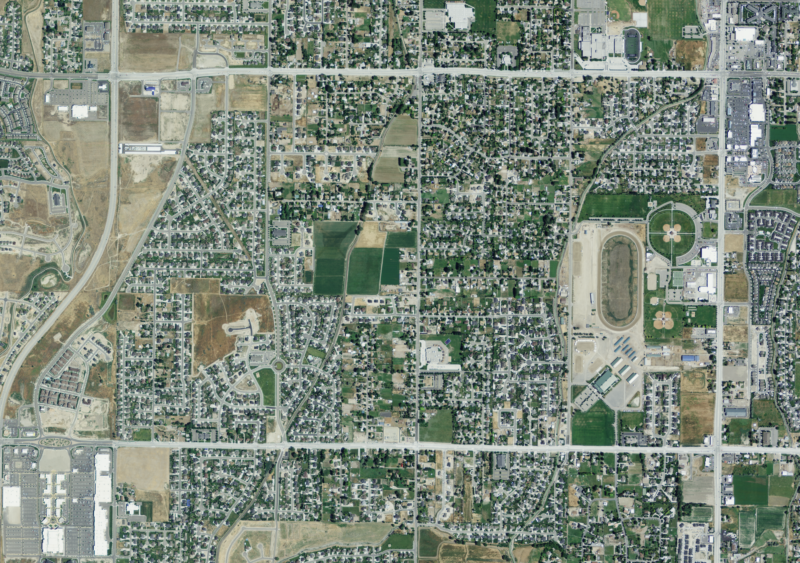

In [7]:
create_image(item_old)

2018-08-28 00:00:00+00:00


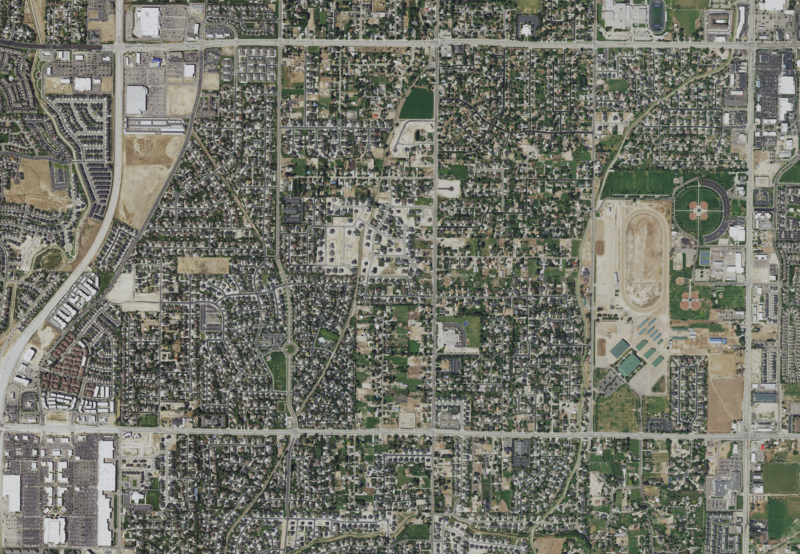

In [8]:
create_image(item_new)